# 基于随机森林的银行客户订阅定期存款预测案例

## 0.前言

在本案例中，我们使用了葡萄牙银行机构营销数据集(https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) ，我们选取的是网页中提供的四个数据集中的第四个：bank.csv，其中包含了4521个样本,17个特征。我们主要利用其中和客户个人信息及接受的营销活动相关的变量（前16个），通过特征预处理、变换等方法构建基本特征，建立随机森林的模型，对'客户是否订阅定期存款'变量（变量名为'y'）进行预测，并评估模型的预测效果。特征的详细含义如下表所示。

In [438]:
import pandas as pd
summary = pd.read_csv('summary.csv',encoding="gb2312")
summary

,变量序号,变量类型,变量名,变量含义,备注
0,1,数值变量,age,银行客户年龄,无
1,2,类别变量,job,工作类型,"分类：{'admin.','blue-collar','entrepreneur','hou..."
2,3,类别变量,marital,婚姻状况,"分类：{'divorced','married','single'}"
3,4,类别变量,education,教育情况,"分类：{primary','secondary','tertiary'}"
4,5,类别变量,default,是否信用违约,分类：{'是'，'不是'}
5,6,数值变量,balance,余额,无
6,7,类别变量,housing,是否有住房贷款,分类：{'是'，'不是'}
7,8,类别变量,loan,是否有个人贷款,分类：{'是'，'不是'}
8,9,类别变量,contact,联系方式类型,"分类：{'cellular','telephone'}"
9,10,类别变量,day,上次联系的日期（一个月中的几号）,无


## 1. 数据准备

In [3]:
## 当前python的运行版本
import sys
print("The Python version is %s.%s.%s" % sys.version_info[:3])
## 导入相关包
import pandas as pd
import numpy as np
from sklearn import grid_search
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The Python version is 3.6.1


In [4]:
## 数据导入
df = pd.read_csv('bank.csv',sep=";")
print(df.shape)
df.head(5)

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## 2.特征工程

### 1) 缺失值处理

通过检查数据，我们发现数据不存在NaN，但部分特征如'job'、'education'，存在小部分取值为'unknown'的样本，对于这些样本，我们采取用众数替换的方法。而对于特征如'contact'、'poutcome'，有相当比重的数据为'unknown'，所以我们考虑保留'unknown'。

In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
## 查看job的众数
print(df.job.value_counts().head(1))
## 将样本job为"unknown"的替换为job的众数"management"
df.job[df.job == "unknown"] = "management"

management    969
Name: job, dtype: int64


In [7]:
## 查看education的众数
print(df.education.value_counts().head(1))
## 将样本education为"unknown"的替换为education的众数"secondary"
df.education[df.education == "unknown"] = "secondary"

secondary    2306
Name: education, dtype: int64


In [8]:
print(df.contact.value_counts())

cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64


In [9]:
print(df.poutcome.value_counts())

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64


### 2) 类别变量的预处理

对于类别变量，我们分有序和无序两种分别处理。对于有序的类别变量，如'education'，我们将小学（'primary'），中学（'secondary'）和大学（'tertiary'）分别编码为1，2，3。对于无序的类别变量，若是逻辑型的二值变量，如'default','housing','loan','y'，我们直接编码为0，1；若是有多类别的类别变量，如'job','marital','contact','month'，我们采用离散特征编码，将其转化为虚拟变量。

In [10]:
## 处理'education'
education_mapping = {
    'primary':1,
    'secondary':2,
    'tertiary':3
}
df['education']=df['education'].map(education_mapping)
default_mapping = {label:idx for idx,label in enumerate(np.unique([df['default']]))}

## 处理'default','housing','loan','y'
df['default']=df['default'].map(default_mapping)
housing_mapping = {label:idx for idx,label in enumerate(np.unique([df['housing']]))}
df['housing']=df['housing'].map(housing_mapping)
loan_mapping = {label:idx for idx,label in enumerate(np.unique([df['loan']]))}
df['loan']=df['loan'].map(loan_mapping)
y_mapping = {label:idx for idx,label in enumerate(np.unique([df['y']]))}
df['y']=df['y'].map(y_mapping)

## 处理'job','marital','contact','month','poutcome'
df_sub_1 = pd.get_dummies(df[['job','marital','contact','month','poutcome']])

##### 我们把完成了1）、2）部分的预处理的数据作为基础数据集，记为df_full1。

In [11]:
df_sub_2 = df[['age','education', 'default', 'balance', 'housing',
       'loan', 'day', 'duration', 'campaign', 'pdays',
       'previous','y']]
df_full1 = pd.concat([df_sub_1,df_sub_2],axis=1)

In [12]:
print(df_full1.shape)
df_full1.head(5)

(4521, 45)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
0,0,0,0,0,0,0,0,0,0,0,...,0,1787,0,0,19,79,1,-1,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,4789,1,1,11,220,1,339,4,0
2,0,0,0,0,1,0,0,0,0,0,...,0,1350,1,0,16,185,1,330,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,1476,1,1,3,199,4,-1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,5,226,1,-1,0,0


### 3) 其他预处理

前面提到'campaign'这个变量，即'该次营销活动期间和客户联系的次数',若取值为999，则代表该客户以前没有联系过，但我们选取的数据集中不存在这样的样本，所以对于这个变量不做额外处理。

In [13]:
df.campaign.unique()

array([ 1,  4,  2,  5,  3,  6, 18, 10,  9,  7, 12, 14, 13, 24, 11,  8, 29,
       32, 16, 22, 15, 30, 25, 21, 17, 19, 23, 20, 50, 28, 31, 44])

'年龄'变量分布19-87岁之间，我们考虑将其离散化，分别划分成19-30，30-55以及 >55三个年龄段，并编码为1，2，3.

In [14]:
df = pd.read_csv('bank.csv',sep=";")
print("MAX={} ; MIN={}".format(df.age.min(),df.age.max()))
for i in range(len(df.age)):
    if (df['age'][i] < 30):
        df['age'][i] = 1
    elif (df['age'][i] < 55):
        df['age'][i] = 2
    else:
        df['age'][i] = 3

MAX=19 ; MIN=87


In [15]:
df.job[df.job == "unknown"] = "management"
df.education[df.education == "unknown"] = "secondary"
education_mapping = {
    'primary':1,
    'secondary':2,
    'tertiary':3
}
df['education']=df['education'].map(education_mapping)
default_mapping = {label:idx for idx,label in enumerate(np.unique([df['default']]))}
df['default']=df['default'].map(default_mapping)
housing_mapping = {label:idx for idx,label in enumerate(np.unique([df['housing']]))}
df['housing']=df['housing'].map(housing_mapping)
loan_mapping = {label:idx for idx,label in enumerate(np.unique([df['loan']]))}
df['loan']=df['loan'].map(loan_mapping)
y_mapping = {label:idx for idx,label in enumerate(np.unique([df['y']]))}
df['y']=df['y'].map(y_mapping)
df1 = pd.get_dummies(df[['job','marital','contact','month','poutcome']])
df2 = df[['age','education', 'default', 'balance', 'housing',
       'loan', 'day', 'duration', 'campaign', 'pdays',
       'previous','y']]
df_full2 = pd.concat([df1,df2],axis=1)

##### 在之前1）、2）部分的预处理的基础上，我们将年龄离散化，数据集记为df_full2。

## 3.模型训练与评估

### a）评估指标的选择

在训练模型之前，我们先选定评估指标，以进行更好的训练。我们备选的评价指标有准确率、精确率、召回率、F1、ROC/AUC、PRC等。

我们通过下图检查要预测的变量'客户是否订阅定期存款'的分布情况，发现数据存在样本不平衡问题，样本中y为'是'与'否'的比例大约为1：8。通过查阅资料得知，面对样本标签不平衡的问题，更能合理评估模型的指标有F1、G-mean以及ROC/AUC。所以在模型的选择上，我们主要参考F1和AUC。

0    4000
1     521
Name: y, dtype: int64


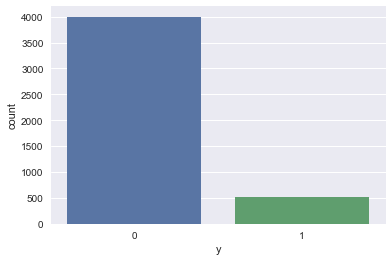

In [16]:
print(df.y.value_counts())
sns.countplot(df.y)

### b）调参

我们将处理好的数据分为训练数据和测试数据(比例为训练数据0.8，测试数据0.2)，并通过调节或参考经验确定参数'n_estimators'，'criterion'，'max_depth'，
'max_features'
'min_samples_leaf'， 'min_samples_split'，'min_weight_fraction_leaf'。调参过程基于基本数据集df_full1。整个训练过程将random_state设为0。

#### min_samples_split，min_samples_leaf，max_features

In [453]:
print(df_full1.shape)

(4521, 45)


'min_samples_split'：本数据集的大小为4521*45，样本量不算大，通过查阅资料，我们了解到这个参数在样本量不大的时候，无需调整，故取默认值为2。

'min_samples_leaf'：这个参数在样本量不大的时候，无需调整，故取默认值为1。

'max_features'：在样本特征小于50时，也无需调整，故也用默认的"None"。

#### n_estimators

通过查阅资料，我们了解到子模型数'n_estimators'这个参数对模型性能的影响是基本单调的，在一定区间内，随着n_estimators的增加，模型性能提高，但只是在特定区间内。所以我们首先单独对这一参数进行调整，范围参考以10为步长，从1至201的取值。进行调参时，评判使用的标准scoring采取auc。

In [17]:
X = df_full1.iloc[:,list(range(0,(df_full1.shape[1]-1)))]
y = df_full1["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0), parameters,
                               scoring ='roc_auc' ,
                               cv = 5)
clf.fit(X_train,y_train)
## 模型参数n_estimators的最优取值
clf.best_params_

{'n_estimators': 171}

#### criterion，max_depth，min_weight_fraction_leaf

接着，对于其他参数'criterion'，'max_depth'，'min_weight_fraction_leaf'，使用网格搜索进行粗调。'criterion'在'entropy','gini'中选择，'max_depth'参考经验取值，以10为步长，取从10至100,'min_weight_fraction_leaf'参考经验取值，以0.1位步长，取从0.0至0.5。

In [18]:
parameters = [{'criterion':['entropy','gini'],
      'max_depth':list(range(10,100,10)),
      'min_weight_fraction_leaf':[0.0,0.1,0.2,0.3,0.4,0.5]
     }]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,n_estimators=171), parameters,
                               scoring ='roc_auc' ,
                               cv=5)
clf.fit(X_train,y_train)
## 以下是我们得到的模型参数criterion，max_depth，min_weight_fraction_leaf的最优取值
clf.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'min_weight_fraction_leaf': 0.0}

在确定了criterion，max_depth，min_weight_fraction_leaf的最优取值后，我们基于这些，再次调节n_estimators。

In [19]:
## 再次调节n_estimators

parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,criterion='entropy', max_depth=30, min_weight_fraction_leaf=0.0), 
                               parameters,
                               scoring ='roc_auc' ,
                               cv = 5)
clf.fit(X_train,y_train)
## 模型参数n_estimators的最优取值
clf.best_params_

{'n_estimators': 191}

### 1）基本模型

我们可以用上述最优参数重新训练模型，并通过准确率、精确率、召回率、F1、AUC等指标在测试集上评估模型的表现。以下以完成了1）、2）部分的预处理的基础数据集'df_full1'为例，评估其表现。

df_full1's evaluation:
Accuracy=0.8895
             precision    recall  f1-score   support

          0       0.90      0.98      0.94       793
          1       0.64      0.24      0.35       112

avg / total       0.87      0.89      0.87       905

AUC - ROC : 0.6111


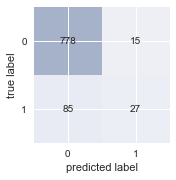

In [21]:
clf = RandomForestClassifier(random_state=0,n_estimators=191, criterion='entropy', max_depth=30, min_weight_fraction_leaf=0.0) 
clf.fit(X_train,y_train)
print("df_full1's evaluation:")
print("Accuracy={}".format(round((clf.fit(X_train,y_train).score(X_test, y_test)),4)))
print(classification_report(y_test, clf.predict(X_test)))
print ("AUC - ROC : {}".format(round(roc_auc_score(y_test, clf.predict(X_test)),4)))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=np.array(cnf_matrix))
plt.show()

我们将考虑的参数都调至最优取值，重新训练模型，得到f1=0.87，AUC=0.6111的结果。

### 2）尝试1： 将年龄离散化（表现稍提升）

使用将年龄分段的数据集'df_full2'，并直接使用以上调参的最优结果，我们发现模型的表现稍有提升。

Accuracy=0.8939
             precision    recall  f1-score   support

          0       0.90      0.98      0.94       793
          1       0.69      0.26      0.38       112

avg / total       0.88      0.89      0.87       905

AUC - ROC : 0.6213


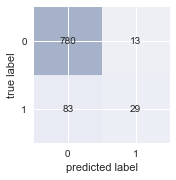

In [22]:
X = df_full2.iloc[:,list(range(0,(df_full2.shape[1]-1)))]
y = df_full2["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    
clf = RandomForestClassifier(random_state=0,n_estimators=191, criterion='entropy', max_depth=30, min_weight_fraction_leaf=0.0)
clf.fit(X_train,y_train)
print("Accuracy={}".format(round((clf.fit(X_train,y_train).score(X_test, y_test)),4)))
print(classification_report(y_test, clf.predict(X_test)))
print ("AUC - ROC : {}".format(round(roc_auc_score(y_test, clf.predict(X_test)),4)))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=np.array(cnf_matrix))
plt.show()

我们基于新的数据集，重复上述调参步骤（经过多次调参，发现参数'min_weight_fraction_leaf'的最优始终保持0.0，故在此不对其作调整），再次评估模型表现，f1仍为0.87，AUC稍有提升为0.6225。

In [24]:
## 调 n_estimators
parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0), parameters,
                               scoring ='roc_auc' ,
                               cv=5)
clf.fit(X_train,y_train)
print(clf.best_params_)

## 调 criterion，max_depth，min_weight_fraction_leaf
parameters = [{'criterion':['entropy','gini'],
      'max_depth':list(range(10,100,10))
     }]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,n_estimators=clf.best_params_['n_estimators']), 
                               parameters,
                               scoring ='roc_auc' ,
                               cv=5)
clf.fit(X_train,y_train)

## 以下是我们得到的模型参数criterion，max_depth，min_weight_fraction_leaf的最优取值
print(clf.best_params_)

{'n_estimators': 171}
{'criterion': 'entropy', 'max_depth': 20}


In [25]:
## 基于criterion，max_depth，min_weight_fraction_leaf的最优取值，再次调节n_estimators

parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,criterion='entropy', max_depth=20, min_weight_fraction_leaf=0.0), 
                               parameters,
                               scoring ='roc_auc' ,
                               cv = 5)
clf.fit(X_train,y_train)
## 模型参数n_estimators的最优取值
print(clf.best_params_)

{'n_estimators': 151}


df_full2's evaluation:
Accuracy=0.8961
             precision    recall  f1-score   support

          0       0.90      0.99      0.94       793
          1       0.72      0.26      0.38       112

avg / total       0.88      0.90      0.87       905

AUC - ROC : 0.6225


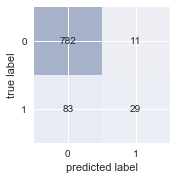

In [26]:
clf = RandomForestClassifier(random_state=0,n_estimators=151, criterion='entropy', max_depth=20, min_weight_fraction_leaf=0.0) 
clf.fit(X_train,y_train)
print("df_full2's evaluation:")
print("Accuracy={}".format(round((clf.fit(X_train,y_train).score(X_test, y_test)),4)))
print(classification_report(y_test, clf.predict(X_test)))
print ("AUC - ROC : {}".format(round(roc_auc_score(y_test, clf.predict(X_test)),4)))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=np.array(cnf_matrix))
plt.show()

### 3）尝试2： 去掉一些不重要的特征（表现未提升）

接下来，我们可以检查一下变量的重要性，并考虑下一步特征的改进。

In [27]:
label = X.columns[0:]
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d %-*s %f" % (f+1,30,label[f],importances[indices[f]]))

 1 job_admin.                     0.282697
 2 job_blue-collar                0.099044
 3 job_entrepreneur               0.084025
 4 job_housemaid                  0.044595
 5 job_management                 0.041245
 6 job_retired                    0.035272
 7 job_self-employed              0.027517
 8 job_services                   0.025244
 9 job_student                    0.021238
10 job_technician                 0.020731
11 job_unemployed                 0.017095
12 marital_divorced               0.015187
13 marital_married                0.014746
14 marital_single                 0.014670
15 contact_cellular               0.013717
16 contact_telephone              0.013396
17 contact_unknown                0.012749
18 month_apr                      0.012732
19 month_aug                      0.012713
20 month_dec                      0.012181
21 month_feb                      0.012143
22 month_jan                      0.012054
23 month_jul                      0.011863
24 month_ju

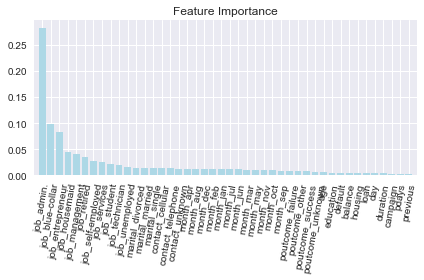

In [28]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
       importances[indices],
       color = 'lightblue',
       align = 'center')
plt.xticks(range(X_train.shape[1]),
          label,rotation = 80)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

通过观察变量的重要性，我们尝试把排在最后五名的特征'day','duration','campaign','pdays','previous'删除，但模型表现并没有变好。

In [29]:
df2 = df[['age','education', 'default', 'balance', 'housing',
       'loan','y']]
df_full_minus = pd.concat([df1,df2],axis=1)
X = df_full_minus.iloc[:,list(range(0,(df_full_minus.shape[1]-1)))]
y = df_full_minus["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    

In [31]:
### 调参

## 调 n_estimators
parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0), parameters,scoring ='roc_auc',cv=5)
clf.fit(X_train,y_train)
print(clf.best_params_)
## 调 criterion，max_depth，min_weight_fraction_leaf
parameters = [{'criterion':['entropy','gini'],
      'max_depth':list(range(10,100,10)),
      'min_weight_fraction_leaf':[0.0,0.1,0.2,0.3,0.4,0.5]
     }]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,n_estimators=clf.best_params_['n_estimators']), parameters,
                              scoring ='roc_auc',cv=5)
clf.fit(X_train,y_train)

## 以下是我们得到的模型参数criterion，max_depth，min_weight_fraction_leaf的最优取值

print(clf.best_params_)

{'n_estimators': 91}
{'criterion': 'gini', 'max_depth': 10, 'min_weight_fraction_leaf': 0.0}


In [32]:
## 基于criterion，max_depth，min_weight_fraction_leaf的最优取值，再次调节n_estimators

parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,criterion='gini', max_depth=10, min_weight_fraction_leaf=0.0), 
                               parameters,
                               scoring ='roc_auc' ,
                               cv = 5)
clf.fit(X_train,y_train)
## 模型参数n_estimators的最优取值
print(clf.best_params_)

{'n_estimators': 181}


df_full_minus's evaluation:
Accuracy=0.8873
             precision    recall  f1-score   support

          0       0.89      1.00      0.94       793
          1       0.86      0.11      0.19       112

avg / total       0.88      0.89      0.85       905

AUC - ROC : 0.5523


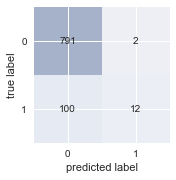

In [36]:
clf = RandomForestClassifier(random_state=0,n_estimators=181, criterion='gini', max_depth=10,min_weight_fraction_leaf=0.0) 
clf.fit(X_train,y_train)
print("df_full_minus's evaluation:")
print("Accuracy={}".format(round((clf.fit(X_train,y_train).score(X_test, y_test)),4)))
print(classification_report(y_test, clf.predict(X_test)))
print ("AUC - ROC : {}".format(round(roc_auc_score(y_test, clf.predict(X_test)),4)))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=np.array(cnf_matrix))
plt.show()

### 4）尝试3：将部分数值变量离散化（表现略提升）

删除低重要性变量不可行，我们接着考虑其他处理方法，结合前面将年龄离散化得到了比较好的效果，我们尝试将'balance','duration'这类代表金额或时长的低重要性的数值变量进行等距或等频率离散化。将'day'（一个月中的几号）这个变量进行等距的离散化，即划分为月初，月中，月末，编码为1，2，3.

In [37]:
## 处理'balance'
df['balance2'] = pd.cut(df.balance, bins=30)
print("equal binwidth:")
print(df.balance2.value_counts())
df['balance3'] = pd.qcut(df.balance, q=15, labels=False)
print("\nequal frequency:")
pd.value_counts(df.balance3)

equal binwidth:
(-829.633, 1653.733]      3455
(1653.733, 4137.1]         624
(4137.1, 6620.467]         205
(6620.467, 9103.833]        94
(9103.833, 11587.2]         41
(-3387.501, -829.633]       32
(11587.2, 14070.567]        23
(14070.567, 16553.933]      17
(16553.933, 19037.3]         7
(21520.667, 24004.033]       7
(19037.3, 21520.667]         6
(26487.4, 28970.767]         4
(24004.033, 26487.4]         4
(68704.633, 71188.0]         1
(41387.6, 43870.967]         1
(33937.5, 36420.867]         0
(66221.267, 68704.633]       0
(28970.767, 31454.133]       0
(36420.867, 38904.233]       0
(38904.233, 41387.6]         0
(43870.967, 46354.333]       0
(46354.333, 48837.7]         0
(48837.7, 51321.067]         0
(51321.067, 53804.433]       0
(53804.433, 56287.8]         0
(56287.8, 58771.167]         0
(58771.167, 61254.533]       0
(61254.533, 63737.9]         0
(63737.9, 66221.267]         0
(31454.133, 33937.5]         0
Name: balance2, dtype: int64

equal frequency:


1     421
4     306
8     304
11    302
14    302
0     302
10    301
6     301
13    301
12    301
5     300
9     299
7     298
3     293
2     190
Name: balance3, dtype: int64

通过等距离散化，我们发现'balance'这个变量是严重右偏的，所以我们考虑等频率离散化，以保证各组相对平衡。对于'duration'也作同理处理。

In [38]:
## 处理'duration'
df['duration2'] = pd.cut(df.duration, bins=20)
print("equal binwidth:")
print(df.duration2.value_counts())
df['duration3'] = pd.qcut(df.duration, q=15, labels=False)
print("\nequal frequency:")
pd.value_counts(df.duration3)

equal binwidth:
(0.979, 155.05]      1899
(155.05, 306.1]      1386
(306.1, 457.15]       557
(457.15, 608.2]       268
(608.2, 759.25]       181
(759.25, 910.3]        86
(910.3, 1061.35]       59
(1061.35, 1212.4]      32
(1363.45, 1514.5]      16
(1212.4, 1363.45]      13
(1514.5, 1665.55]      10
(1665.55, 1816.6]       6
(1967.65, 2118.7]       4
(2722.9, 2873.95]       1
(1816.6, 1967.65]       1
(2420.8, 2571.85]       1
(2873.95, 3025.0]       1
(2118.7, 2269.75]       0
(2269.75, 2420.8]       0
(2571.85, 2722.9]       0
Name: duration2, dtype: int64

equal frequency:


0     309
6     308
1     305
3     304
11    303
2     303
14    302
10    302
12    302
8     300
4     300
9     299
13    298
5     296
7     290
Name: duration3, dtype: int64

In [39]:
df['day2'] = pd.cut(df.day, bins=3)
print(df.day2.value_counts())
labels_age2, levels_age2 = pd.factorize(df.day2)
df['day2'] = labels_age2

(11.0, 21.0]    1923
(0.97, 11.0]    1488
(21.0, 31.0]    1110
Name: day2, dtype: int64


##### 在之前1）、2）部分的预处理和年龄离散化的基础上，我们将'balance','duration','day'离散化，数据集记为df_full3。

In [40]:
df2 = df[['age','education', 'default', 'balance3', 'housing',
       'loan', 'day2', 'duration3', 'campaign', 'pdays',
       'previous','y']]
df_full3 = pd.concat([df1,df2],axis=1)
X = df_full3.iloc[:,list(range(0,(df_full3.shape[1]-1)))]
y = df_full3["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    

In [41]:
### 调参

## 调 n_estimators
parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0), parameters,scoring ='roc_auc',cv=5)
clf.fit(X_train,y_train)
print(clf.best_params_)
## 调 criterion，max_depth，min_weight_fraction_leaf
parameters = [{'criterion':['entropy','gini'],
      'max_depth':list(range(10,100,10)),
      'min_weight_fraction_leaf':[0.0,0.1,0.2,0.3,0.4,0.5]
     }]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,n_estimators=clf.best_params_['n_estimators']), parameters,
                              scoring ='roc_auc',cv=5)
clf.fit(X_train,y_train)

## 以下是我们得到的模型参数criterion，max_depth，min_weight_fraction_leaf的最优取值

print(clf.best_params_)

{'n_estimators': 141}
{'criterion': 'entropy', 'max_depth': 20, 'min_weight_fraction_leaf': 0.0}


In [43]:
## 基于criterion，max_depth，min_weight_fraction_leaf的最优取值，再次调节n_estimators

parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,criterion='entropy', max_depth=20, min_weight_fraction_leaf=0.0), 
                               parameters,
                               scoring ='roc_auc' ,
                               cv = 5)
clf.fit(X_train,y_train)
## 模型参数n_estimators的最优取值
print(clf.best_params_)

{'n_estimators': 111}


Accuracy=0.8917
             precision    recall  f1-score   support

          0       0.91      0.98      0.94       793
          1       0.64      0.29      0.40       112

avg / total       0.87      0.89      0.87       905

AUC - ROC : 0.6315


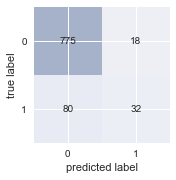

In [44]:
clf = RandomForestClassifier(random_state=0,n_estimators=111, criterion='entropy', max_depth=20, min_weight_fraction_leaf=0.0) 
clf.fit(X_train,y_train)
print("Accuracy={}".format(round((clf.fit(X_train,y_train).score(X_test, y_test)),4)))
print(classification_report(y_test, clf.predict(X_test)))
print ("AUC - ROC : {}".format(round(roc_auc_score(y_test, clf.predict(X_test)),4)))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=np.array(cnf_matrix))
plt.show()

从上表可以看出，这些变量'balance','duration','day'的离散化，f1仍然为0.87，AUC提升到0.6238。

### 5）尝试4：将部分数值变量标准化（表现提升）

我们把在现有数据的基础上，我们可以考虑对'balance','duration','day'进行标准化。

In [46]:
df['balance2'] = StandardScaler().fit_transform(df.balance.reshape(-1,1))
df['duration2'] = StandardScaler().fit_transform(df.duration.reshape(-1,1))
df['day2'] = StandardScaler().fit_transform(df.day.reshape(-1,1))
df2 = df[['age','education', 'default', 'balance2', 'housing',
       'loan', 'day2', 'duration2', 'campaign', 'pdays',
       'previous','y']]
df_full4 = pd.concat([df1,df2],axis=1)

##### 在之前1）、2）部分的预处理和年龄离散化的基础上，我们将'balance','duration','day'标准化，数据集记为df_full4。

In [47]:
X = df_full4.iloc[:,list(range(0,(df_full4.shape[1]-1)))]
y = df_full4["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)    

In [48]:
### 调参

## 调 n_estimators
parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0), parameters,scoring ='roc_auc',cv=5)
clf.fit(X_train,y_train)
print(clf.best_params_)
## 调 criterion，max_depth，min_weight_fraction_leaf
parameters = [{'criterion':['entropy','gini'],
      'max_depth':list(range(10,100,10))
     }]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,n_estimators=clf.best_params_['n_estimators']), parameters,
                              scoring ='roc_auc',cv=5)
clf.fit(X_train,y_train)

## 以下是我们得到的模型参数criterion，max_depth，min_weight_fraction_leaf的最优取值

print(clf.best_params_)

{'n_estimators': 171}
{'criterion': 'entropy', 'max_depth': 20}


In [49]:
## 基于criterion，max_depth，min_weight_fraction_leaf的最优取值，再次调节n_estimators

parameters = [{'n_estimators':list(range(1,201,10))}]
clf = grid_search.GridSearchCV(RandomForestClassifier(random_state=0,criterion='entropy', max_depth=20, min_weight_fraction_leaf=0.0), 
                               parameters,
                               scoring ='roc_auc' ,
                               cv = 5)
clf.fit(X_train,y_train)
## 模型参数n_estimators的最优取值
print(clf.best_params_)

{'n_estimators': 151}


Accuracy=0.8972
             precision    recall  f1-score   support

          0       0.91      0.99      0.94       793
          1       0.73      0.27      0.39       112

avg / total       0.88      0.90      0.88       905

AUC - ROC : 0.627


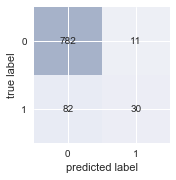

In [50]:
clf = RandomForestClassifier(random_state=0,n_estimators=151, criterion='entropy', max_depth=20,min_weight_fraction_leaf=0.0) 
clf.fit(X_train,y_train)
print("Accuracy={}".format(round((clf.fit(X_train,y_train).score(X_test, y_test)),4)))
print(classification_report(y_test, clf.predict(X_test)))
print ("AUC - ROC : {}".format(round(roc_auc_score(y_test, clf.predict(X_test)),4)))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=np.array(cnf_matrix))
plt.show()

从上表可以看出，这些变量'balance','duration','day'的标准化，模型性能有所提升，f1升至0.88，AUC提升到0.627。

### 6）尝试5：尝试多项式变换（表现提升）

In [52]:
X = df_full4.iloc[:,list(range(0,(df_full4.shape[1]-1)))]
y = df_full4["y"] 
poly = PolynomialFeatures(2)
temp = poly.fit_transform(X)
df_full5 = pd.DataFrame(temp, columns=poly.get_feature_names())
df_full5.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x40^2,x40 x41,x40 x42,x40 x43,x41^2,x41 x42,x41 x43,x42^2,x42 x43,x43^2
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.506746,-0.711861,0.711861,-0.000000,1.0,-1.0,0.0,1.0,-0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.028627,-0.169194,-57.356729,-0.676776,1.0,339.0,4.0,114921.0,1356.0,16.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.092354,-0.303898,-100.286486,-0.303898,1.0,330.0,1.0,108900.0,330.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.062508,-1.000066,0.250017,-0.000000,16.0,-4.0,0.0,1.0,-0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021346,-0.146102,0.146102,-0.000000,1.0,-1.0,0.0,1.0,-0.0,0.0


由于将变量作非线性变换后，数据列数大大增加到1035。我们暂时不做参数调节，保留基本模型的最优参数。

Accuracy=0.9006
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       793
          1       0.66      0.40      0.50       112

avg / total       0.89      0.90      0.89       905

AUC - ROC : 0.6864


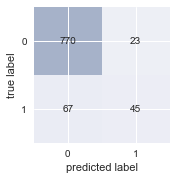

In [55]:
X = df_full5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  
clf = RandomForestClassifier(random_state=0,n_estimators=171, criterion='entropy', max_depth=30, min_weight_fraction_leaf=0.0) 
clf.fit(X_train,y_train)
print("Accuracy={}".format(round((clf.fit(X_train,y_train).score(X_test, y_test)),4)))
print(classification_report(y_test, clf.predict(X_test)))
print ("AUC - ROC : {}".format(round(roc_auc_score(y_test, clf.predict(X_test)),4)))
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=np.array(cnf_matrix))
plt.show()

从上表可以看出，特征的多项式变换使得模型表现有所提升，f1提升至0.89，AUC提升到0.6864。

由于多项式变换之后，模型表现提升明显，我们猜测是否存在非线性的特征贡献明显，但进一步检查一下变量的重要性，发现比较重要的变量依然是单个变量，而非变量的组合及非线性变换。

In [60]:
## 查看重要性排前50的变量
label = X.columns[0:]
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(50):
    print("%2d %-*s %f" % (f+1,30,label[f],importances[indices[f]]))

 1 1                              0.032738
 2 x0                             0.026955
 3 x1                             0.026100
 4 x2                             0.026046
 5 x3                             0.024505
 6 x4                             0.023097
 7 x5                             0.022913
 8 x6                             0.022845
 9 x7                             0.016468
10 x8                             0.014440
11 x9                             0.014102
12 x10                            0.011514
13 x11                            0.008864
14 x12                            0.008755
15 x13                            0.008417
16 x14                            0.007858
17 x15                            0.007741
18 x16                            0.007724
19 x17                            0.007663
20 x18                            0.007501
21 x19                            0.007474
22 x20                            0.007459
23 x21                            0.007425
24 x22     

## 4. 小结

本案例基于葡萄牙银行机构营销数据集的4521个样本,17个特征。利用其中和客户个人信息及接受的营销活动相关的变量（前16个），建立随机森林的模型，对'客户是否订阅定期存款'变量（变量名为'y'）进行预测。

在数据的特征变换方面，除了基本模型，我们尝试了将年龄变量离散化，剔除不重要的特征，其他数值变量离散化，数值变量标准化以及特征多项式变换等方式。

在调参方面，考虑到我们使用的数据集比较小，故'max_features'，'min_samples_leaf'，'min_samples_split'我们都采用默认值，而对于'n_estimators'，'criterion'，'entropy'以及'min_weight_fraction_leaf'，我们采用先调节'n_estimators'，再用grid search调'criterion'，'entropy'以及'min_weight_fraction_leaf'，再回调'n_estimators'的方式。在最优模型中，这些参数的最优值为n_estimators=171, criterion='entropy', max_depth=30, min_weight_fraction_leaf=0.0。

在模型评估方面，由于数据存在样本不平衡问题，所以我们主要参考F1和AUC作为模型评估指标，我们先后尝试了多种特征变换的方式，并依次进行了调参，其中特征多项式变换之后的模型收到了最好的评估效果，而数值变量的离散化、标准化等特征变换均收到了模型性能提升的效果。具体如下：

In [61]:
print('基本模型：F1= 0.87，AUC=0.6111\n年龄离散化：F1= 0.87，AUC=0.6225\n保留重要特征：F1= 0.85，AUC=0.5523\n其他数值变量离散化：F1= 0.87，AUC=0.6315\n数值变量标准化：F1= 0.88，AUC=0.627\n特征多项式变换：F1= 0.89，AUC=0.6864')

基本模型：F1= 0.87，AUC=0.6111
年龄离散化：F1= 0.87，AUC=0.6225
保留重要特征：F1= 0.85，AUC=0.5523
其他数值变量离散化：F1= 0.87，AUC=0.6315
数值变量标准化：F1= 0.88，AUC=0.627
特征多项式变换：F1= 0.89，AUC=0.6864


回顾数据的现实背景，我们发现在对'客户是否订阅定期存款'变量的预测的问题中，按照重要性从高到低的变量分别是，职业类型、婚姻状况、联系方式类型等，其中'职业是否为管理人员'为最重要的变量（虚拟变量），重要性为0.28，之后依次是'职业是否为体力劳动者' （重要性0.099），'职业是否为企业家'（重要性为0.084），'职业是否为家政人员'（重要性为0.045）。 